# Our Notebook

In [20]:
"""
Get data from Open-meteo and store it locally.
"""

import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry
import time

# read city location data
power_consumption_data = pd.read_csv('/content/power_consumption_data.csv')
cities_with_coordinates = power_consumption_data[['City', 'Coordinates']]


# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"

responses = {}

for index, row in cities_with_coordinates.iterrows():
	params = {
		"latitude": float(row['Coordinates'].split(",")[0]),
		"longitude": float(row['Coordinates'].split(",")[1]),
		"start_date": "2021-01-01",
		"end_date": "2024-01-01",
		"hourly": ["temperature_2m", "precipitation", "cloud_cover", "sunshine_duration", "terrestrial_radiation"]
	}
	responses[row['City']] = openmeteo.weather_api(url, params=params)

	#responses.append(openmeteo.weather_api(url, params=params))
	# sleep for 10 seconds to not overwhelm the API calls e.g.
	# Minutely API request limit exceeded. Please try again in one minute.
	time.sleep(10)

print(responses)

hourly_dataframe = pd.DataFrame()
# Process first location. Add a for-loop for multiple locations or weather models
# response = responses[0][0]
for city, resp in responses.items():
	response = resp[0]
	print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
	print(f"Elevation {response.Elevation()} m asl")
	print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
	print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

	# Process hourly data. The order of variables needs to be the same as requested.
	hourly = response.Hourly()
	hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
	hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
	hourly_cloud_cover = hourly.Variables(2).ValuesAsNumpy()
	hourly_sunshine_duration = hourly.Variables(3).ValuesAsNumpy()
	hourly_terrestrial_radiation = hourly.Variables(4).ValuesAsNumpy()

	print("stuff")
	hourly_data = {
		"date": pd.date_range(
		start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
		end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
		freq = pd.Timedelta(seconds = hourly.Interval()),
		inclusive = "left"
	)}

	hourly_data["temperature_2m"] = hourly_temperature_2m
	hourly_data["precipitation"] = hourly_precipitation
	hourly_data["cloud_cover"] = hourly_cloud_cover
	hourly_data["sunshine_duration"] = hourly_sunshine_duration
	hourly_data["terrestrial_radiation"] = hourly_terrestrial_radiation
	hourly_data["city"] = city

	df = pd.DataFrame(data = hourly_data)
	hourly_dataframe = pd.concat([hourly_dataframe, df], ignore_index=True)
print(hourly_dataframe)


hourly_dataframe.to_csv("cities_data_hourly.csv", index = False)



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.05,37.37,27.0,3885.0,661.0,1537.0,606.0,6.6085,344700.0
1,-118.30,34.26,43.0,1510.0,310.0,809.0,277.0,3.5990,176500.0
2,-117.81,33.78,27.0,3589.0,507.0,1484.0,495.0,5.7934,270500.0
3,-118.36,33.82,28.0,67.0,15.0,49.0,11.0,6.1359,330000.0
4,-119.67,36.33,19.0,1241.0,244.0,850.0,237.0,2.9375,81700.0
...,...,...,...,...,...,...,...,...,...
2995,-119.86,34.42,23.0,1450.0,642.0,1258.0,607.0,1.1790,225000.0
2996,-118.14,34.06,27.0,5257.0,1082.0,3496.0,1036.0,3.3906,237200.0
2997,-119.70,36.30,10.0,956.0,201.0,693.0,220.0,2.2895,62000.0
2998,-117.12,34.10,40.0,96.0,14.0,46.0,14.0,3.2708,162500.0


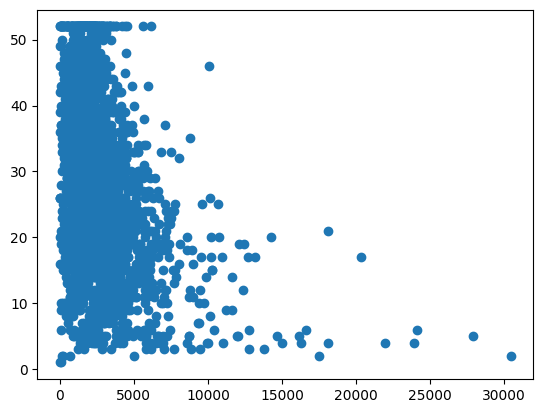

In [23]:
#### Step 1: Import necessary libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# For demonstration, assume we have a DataFrame `weather_data` with necessary columns
weather_data = pd.read_csv('/cities_data_yearly.csv')




#### Step 2: Data Preprocessing
# Normalize the data
scaler = StandardScaler()
weather_features = weather_data[
    ['terrestrial_radiation', 'cloud_cover', 'sunshine_duration', 'temperature_2m', 'precipitation']]
weather_features_scaled = scaler.fit_transform(weather_features)

#### Step 3: Apply Clustering
# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(weather_features_scaled)

# Add the cluster labels to the original DataFrame
weather_data['cluster'] = clusters

#### Step 4: Evaluate and Visualize Clusters
# Visualize the clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=weather_data, x='terrestrial_radiation', y='sunshine_duration', hue='cluster',
                palette='viridis')
plt.title('Clustering of Locations for Photovoltaic Suitability')
plt.xlabel('Average Daily Solar Radiation (kWh/m²/day)')
plt.ylabel('Sunshine Duration (hours/year)')
plt.show()

# Label clusters as good or bad spots
cluster_centers = kmeans.cluster_centers_
good_cluster = np.argmax(cluster_centers[:, 0])  # Assuming higher solar radiation is better
weather_data['pv_suitability'] = weather_data['cluster'].apply(lambda x: 'Good' if x == good_cluster else 'Bad')
print(weather_data[['location', 'pv_suitability']])


In [ ]:
weather_data.groupby('cluster')['cloud_cover'].mean()

In [ ]:
weather_data.columns

In [ ]:
weather_data.groupby('cluster')[['terrestrial_radiation', 'cloud_cover', 'temperature_2m',
       'precipitation', 'sunshine_duration']].mean()

In [ ]:
weather_data[weather_data['location']== 'Berlin']


In [ ]:
!pip install -r /content/requirements.txt
